Implementation of a CNN on MNIST
Taken from pytorch documentation
Taken from pytorch documentation: https://github.com/pytorch/examples/tree/main/mnist


In [26]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import numpy as np
import time
print_figs = True


In [27]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)          # 320 params
        x = F.relu(x)              # 0 params
        x = self.conv2(x)          # 18,496 params
        x = F.relu(x)              # 0 params
        x = F.max_pool2d(x, 2)     # 0 params
        x = self.dropout1(x)       # 0 params
        x = torch.flatten(x, 1)    # 0 params
        x = self.fc1(x)            # 1,179,904 params
        x = F.relu(x)              # 0 params
        x = self.dropout2(x)       # 0 params
        x = self.fc2(x)            # 1,290 params
        output = F.log_softmax(x, dim=1)  # 0 params
        return output
    # Total parameters = 1,200,010

            
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    total_loss = 0.0   # ← added

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()   # ← added

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    return total_loss / len(train_loader)   # ← added



def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item()

            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = correct / len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * accuracy))

    return test_loss   # ← return validation loss instead




In [28]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=14, metavar='N',
                    help='number of epochs to train (default: 14)')
parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                    help='learning rate (default: 1.0)')
parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                    help='Learning rate step gamma (default: 0.7)')
parser.add_argument('--no-accel', action='store_true',
                    help='disables accelerator')
parser.add_argument('--dry-run', action='store_true',
                    help='quickly check a single pass')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--save-model', action='store_true', 
                    help='For Saving the current Model')
args, _ = parser.parse_known_args()

torch.manual_seed(args.seed)

# Standard accelerator selection
if (not args.no_accel) and torch.cuda.is_available():
    device = torch.device("cuda")
elif (not args.no_accel) and hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")   # Apple Silicon
else:
    device = torch.device("cpu")

use_accel = device.type != "cpu"
print("Using device:", device)

train_kwargs = {'batch_size': args.batch_size}
test_kwargs = {'batch_size': args.test_batch_size}
if use_accel:
    accel_kwargs = {'num_workers': 1,
                    'persistent_workers': True,
                    'pin_memory': True,
                    'shuffle': True}
    train_kwargs.update(accel_kwargs)
    test_kwargs.update(accel_kwargs)

transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                    transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                    transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)



Using device: mps


In [29]:
model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

train_losses = []
test_errors = []

scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
start_time = time.perf_counter()   # ← start timer

for epoch in range(1, args.epochs + 1):
    avg_train_loss = train(args, model, device, train_loader, optimizer, epoch)
    test_error = test(model, device, test_loader)

    train_losses.append(avg_train_loss)
    test_errors.append(test_error)

    scheduler.step()

    print(f"Epoch {epoch}: "
          f"Train Loss = {avg_train_loss:.4f}, "
          f"Val Error = {test_error:.4f}")

running_time = time.perf_counter() - start_time   # ← end timer

if args.save_model:
    torch.save(model.state_dict(), "mnist_cnn.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306055
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.687779
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.814345
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.603297
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.419133
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.365164
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.227459
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.528945
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.149905
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.262869
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.257235
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.256729
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.217723
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.179979
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.424954
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.136998
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.189300
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.127093
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.228486
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.075479
Train Epoch: 1 [12800/60000 (

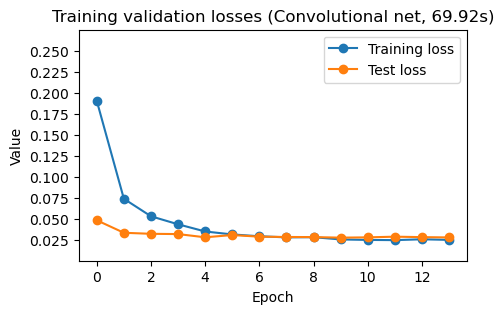

In [37]:
plt.figure(figsize=(5,3))
plt.plot(train_losses, '-o', label="Training loss")
plt.plot(test_errors, '-o', label="Test loss")

plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title(f"Training validation losses (Convolutional net, {running_time:.2f}s)")
plt.ylim(0.0, 0.275)  # set y-axis range
plt.yticks(np.arange(0.025, 0.251, 0.025))  # ticks every 0.025

plt.legend()
if print_figs:
    plt.savefig("../img/week6_CNN_MNIST.pdf", format="pdf", bbox_inches="tight")